In [1]:
import sys
sys.path.append('gym-unbalanced-disk/gym_unbalanced_disk/')
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import os
from matplotlib import pyplot as plt

In [2]:
filename = 'Qfunction1906Morning.pt'

In [3]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [4]:
def show(Q,env):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(10) # give time to open window
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega

In [5]:
def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [6]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

Running from folder


In [7]:
# env.set_discrete_values(discrete_size = 5, minmax = 3.0, div = 3/0.9, rnd = 2) # 5
env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2) # 9 
# env.set_discrete_values_manual([-3.0, -1.5, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1.5, 3.0]) # 11
# env.set_discrete_values_manual([-3.0, -1.5, -0.75, -0.5, -0.25, -0.15, -0.1, 0, 0.1, 0.15, 0.25, 0.5, 0.75, 1.5, 3.0]) # 15

Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]


In [8]:
# Create an instance of Qfunction
Q = Qfunction(env)

# Load Q from the saved file
Q.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [9]:
u,theta,omega = show(Q,env)

pygame 2.4.0 (SDL 2.26.4, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


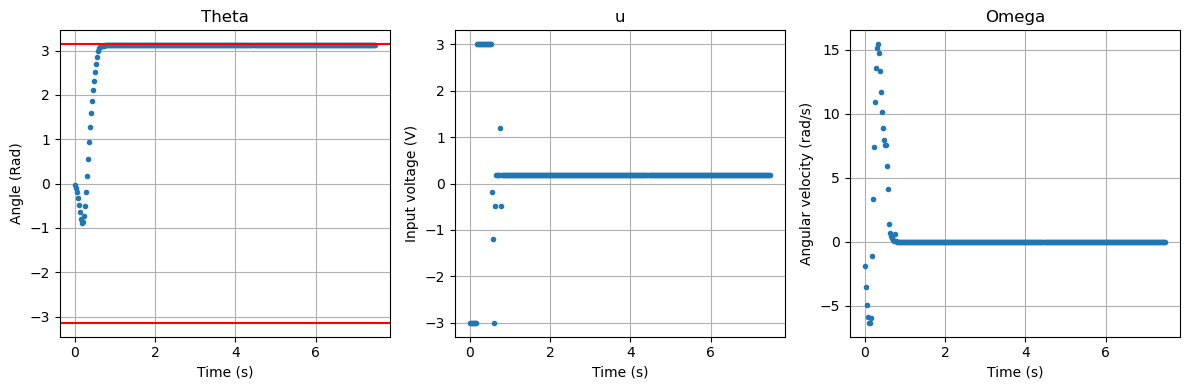

In [10]:
target_angle = np.pi # target set to be balanced on top

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot([i*env.dt for i in range(max_episode_steps)], theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angle (Rad)')
axs[0].axhline(y=target_angle, color='r', linestyle='-')
axs[0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0].grid(True)

# Plot u
axs[1].plot([i*env.dt for i in range(max_episode_steps)], u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Input voltage (V)')
axs[1].grid(True)

# Plot omega
axs[2].plot([i*env.dt for i in range(max_episode_steps)], omega, '.')
axs[2].set_title('Omega')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Angular velocity (rad/s)')
axs[2].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
eval_Q(Q,env)

278.9216829798111

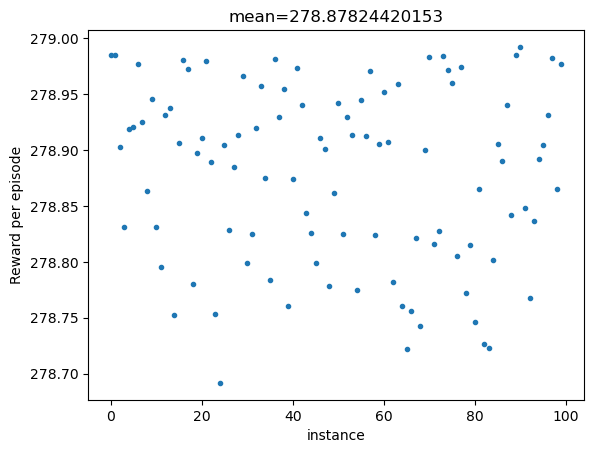

In [12]:
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()

In [13]:
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.ylim(np.min(Rewards)-2.5, np.max(Rewards)+2.5)
plt.axhline(y=np.mean(Rewards), color='r', linestyle='-')
plt.grid(True)
plt.show()